## CPS_ASEC

In [1]:
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

path = '/home/brian/Documents/ASEC/'

### Full-time, full-year workers

In [27]:
ltyear = 2021
pry, lty = [str(ltyear-1), str(ltyear)]
res = {}
for year in [pry, lty]:
    res[year] = {}
    varlist = ['WEWKRS', 'MARSUPWT', 'PRECORD']
    dictfile = f'{path}/data/persfmt{year[2:]}.txt'
    dd = open(dictfile).read()
    p = f'({"|".join(varlist)})\s+(\d+)\s+(\d+)\s'
    cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
            for name, length, start in re.findall(p, dd)}

    datafile = f'{path}/data/asec{year}_pubuse.dat'
    df = (pd.read_fwf(datafile, 
                      colspecs=list(cols.values()), 
                      header=None, 
                      names=list(cols.keys()))
            .query('PRECORD == 3'))
    
    data = df.groupby('WEWKRS').MARSUPWT.sum() / 100_000_000
    res[year]['tot'] = data[1]
    res[year]['sh'] = data[1] / data.sum() * 100

text = (f'{res[lty]["tot"]:.1f} million fully-employed people in '+
        f'{ltyear - 1}, equivalent to {res[lty]["sh"]:.1f} percent '+
        f'of the US population, compared to {res[pry]["tot"]:.1f} '+
        f'million ({res[pry]["sh"]:.1f} percent) in {ltyear - 2}. ')
write_txt(text_dir / 'asec_ftfy_tot.txt', text)
print(text)

105.5 million fully-employed people in 2020, equivalent to 32.3 percent of the US population, compared to 119.2 million (36.6 percent) in 2019. 


### Who are the poor?

Attempt to replicate excellent chart by Matt Bruenig

----

Source: CPS ASEC

In [3]:
# Extract person records for selected variables
variables = ['H_SEQ', 'PPPOS', 
             'PRECORD', 'A_AGE', 'MARSUPWT', 'PERLIS', 
             'SPM_Resources', 'SPM_PovThreshold', 'WKSWORK',
             'PRDISFLG', 'RSNNOTW', 'PYRSN', 'LKWEEKS',
             'SPM_Weight', 'SPM_ID', 'SPM_CapWkCCXpns',
             'SPM_Totval', 'SPM_MedXpns', 'SPM_ChildSupPd',
             'SPM_Poor', 'SPM_NumPer', 'SPM_EIP']

benefits = ['SS_VAL', 'SSI_VAL', 'UC_VAL', 'VET_VAL', 
            'WC_VAL', 'PAW_VAL']

dictfile = f'{path}/data/persfmt21.txt'
dd = open(dictfile).read()
p = f'({"|".join(variables + benefits)})\s+(\d+)\s+(\d+)\s'
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, dd)}

datafile = f'{path}/data/asec2021_pubuse.dat'
df = (pd.read_fwf(datafile, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=list(cols.keys()))
        .query('PRECORD == 3'))

In [4]:
# Categorize population
df['Category'] = (np.where(df.A_AGE < 18, 'Children', 
                  np.where(df.A_AGE > 64, 'Elderly', 
                  np.where(((df.PRDISFLG == 1) | (df.PYRSN == 1) | (df.RSNNOTW == 1)), 'Disabled', 
                  np.where(((df.PYRSN == 3) | (df.RSNNOTW == 4)), 'Students', 
                  np.where(((df.PYRSN == 2) | (df.RSNNOTW == 3)), 'Carers',
                  np.where(((df.PYRSN == 5) | (df.RSNNOTW == 5) | (df.LKWEEKS > 0)), 'Unemployed',         
                  np.where(((df.PYRSN == 4) | (df.RSNNOTW == 2)), 'Early Retired',  
                  np.where(df.WKSWORK > 49, 'Fully Employed', 'All Other')))))))))

df['AGE_GRP'] = pd.cut(df.A_AGE, range(0, 79, 3))

df['SPM'] = np.where(df['SPM_Resources'] < df['SPM_PovThreshold'], 1, 0)
df['OPM'] = np.where(df['PERLIS'] == 1, 1, 0)
df['MARKET_INCOME'] = (df['SPM_Totval'] - 
                       df[['SPM_CapWkCCXpns','SPM_MedXpns', 'SPM_ChildSupPd']].sum(axis=1) - 
                       df[benefits].sum(axis=1).groupby(df['SPM_ID']).transform('sum'))

df['SPM_MI'] = np.where(df['MARKET_INCOME'] < df['SPM_PovThreshold'], 1, 0)
df['MI_GAP'] = ((df['SPM_PovThreshold'] - df['MARKET_INCOME']) / df['SPM_NumPer']) * df['SPM_Weight'] / 100
df['SPM_GAP'] = ((df['SPM_PovThreshold'] - df['SPM_Resources']) / df['SPM_NumPer']) * df['SPM_Weight'] / 100

In [5]:
# Only below poverty line
data = df.query('SPM == 1')
data2 = df.query('OPM == 1')
data3 = df.query('SPM_MI == 1')

results = pd.DataFrame()

# Group share of total
results['SPM'] = (data.groupby('Category').SPM_Weight.sum() / 
                  data.SPM_Weight.sum() * 100).sort_values(ascending=False)

results['OPM'] = (data2.groupby('Category').MARSUPWT.sum() / 
                  data2.MARSUPWT.sum() * 100).sort_values(ascending=False)


results['SPM_MI'] = (data3.groupby('Category').SPM_Weight.sum() / 
                  data3.SPM_Weight.sum() * 100).sort_values(ascending=False)

results.to_csv(data_dir / 'poor.csv', index_label='name')
print(results)

                      SPM        OPM     SPM_MI
Category                                       
Children        23.067288  31.162116  20.811800
Elderly         18.374568  13.424215  33.521200
Disabled        13.987730  15.310101  12.936882
Unemployed       9.647933   8.848502   7.942697
Fully Employed   8.580539   6.353141   7.430565
Carers           8.014144   8.617340   5.110800
All Other        8.010152   7.365298   5.549312
Students         6.387471   5.536543   3.292217
Early Retired    3.930174   3.382744   3.404528


In [6]:
results2 = pd.DataFrame()

# Poverty rate of each group
results2['SPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM'], weights=x['SPM_Weight']))
                     * 100).loc[results.index]
results2['OPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['OPM'], weights=x['MARSUPWT']))
                     * 100).loc[results.index]

results2['SPM_MI'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM_MI'], weights=x['SPM_Weight']))
                     * 100).loc[results.index]

results2.to_csv(data_dir / 'poor2.csv', index_label='name')
print(results2)

                      SPM        OPM     SPM_MI
Category                                       
Children         9.568298  15.948346  24.012857
Elderly          9.459942   8.954905  48.005050
Disabled        20.147453  27.321568  51.832070
Unemployed      13.362611  15.057674  30.599975
Fully Employed   2.370622   2.212626   5.710387
Carers          19.747052  26.994766  35.029187
All Other       11.584153  13.119255  22.323317
Students        23.251313  23.658353  33.335196
Early Retired   17.956293  19.812948  43.267099


<AxesSubplot:>

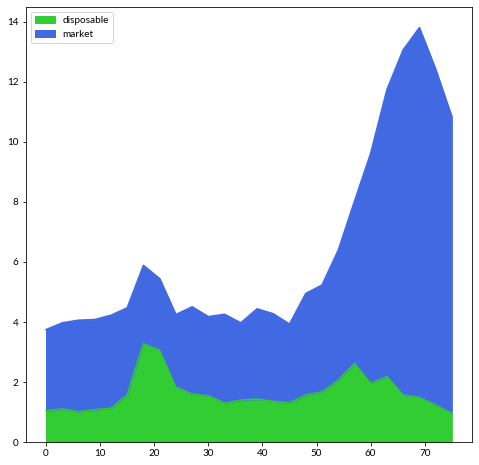

In [7]:
results3 = pd.DataFrame()
results3['disposable'] = (data.groupby('AGE_GRP')['SPM_GAP'].sum() / 3e9)
results3['market'] = (data3.groupby('AGE_GRP')['MI_GAP'].sum() / 3e9) - results3['disposable']

results3.index = [i.left for i in results3.index]
results3.to_csv(data_dir / 'poor_age_latest.csv', index_label='age')
results3.iloc[::-1].plot(kind='area', stacked=True, figsize=(8,8), color=['limegreen', 'royalblue']);

In [8]:
year = 2020
mi_tot = df.query('SPM_MI == 1').MARSUPWT.sum() / 1_000_000 / 100
mi_rt = np.average(df['SPM_MI'], weights=df['MARSUPWT']) * 100
spm_tot = df.query('SPM == 1').MARSUPWT.sum() / 1_000_000 / 100
spm_rt = np.average(df['SPM'], weights=df['MARSUPWT']) * 100
ch_val = mi_tot - spm_tot

text = (f'In {year}, income from labor and capital ownership, called '+
        '\\textit{market income}, was below the Census Bureau threshold '+
        f'for poverty for {mi_tot:.1f} million people in the US, '+
        f'equivalent to {mi_rt:.1f} percent of the population. '+
        'An adjusted measure called \\textit{disposable income} includes market '+
        'income plus income from government programs and tax credits, '
        'and subtracts taxes paid. '+
        '\href{https://www.census.gov/library/publications/2019/demo/p60-268.html}{According} '+
        'to the Census Bureau Supplemental Poverty Measure (SPM), '+
        f'\\textbf{{{spm_tot:.1f} million people are in poverty}} based '+
        f'on their disposable income, equivalent to {spm_rt:.1f} percent of the '+
        'population. Government programs and tax credits moved the income of '+
        f'{ch_val:.1f} million people above the poverty threshold.')

print(text)

write_txt(text_dir / 'poverty_main.txt', text)

groups = ['Children', 'Elderly', 'Disabled', 'Carers', 'Students']
group_share = results.loc[groups, 'SPM'].sum()

text = f'These groups represent {group_share:.1f} percent of those in poverty in {year}.'

write_txt(text_dir / 'poverty_groups.txt', text)

In 2020, income from labor and capital ownership, called \textit{market income}, was below the Census Bureau threshold for poverty for 82.5 million people in the US, equivalent to 25.3 percent of the population. An adjusted measure called \textit{disposable income} includes market income plus income from government programs and tax credits, and subtracts taxes paid. \href{https://www.census.gov/library/publications/2019/demo/p60-268.html}{According} to the Census Bureau Supplemental Poverty Measure (SPM), \textbf{29.8 million people are in poverty} based on their disposable income, equivalent to 9.1 percent of the population. Government programs and tax credits moved the income of 52.8 million people above the poverty threshold.


### 2014 Data for comparison

In [9]:
spm = pd.read_stata(f'{path}/data/spmresearch2014.dta')

In [10]:
dictfile = f'{path}/data/asec2015early_pubuse.dd.txt'
dd = open(dictfile, encoding='iso-8859-1').read()
p = re.compile(f'D ({"|".join(variables + benefits)})\s+(\d+)\s+(\d+)\s+')
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, dd)}

datafile = f'{path}/data/asec2015_pubuse.dat'
df = (pd.read_fwf(datafile, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=list(cols.keys()))
        .query('PRECORD == 3').astype('int'))

In [11]:
df = pd.merge(spm, df, left_on=['h_seq', 'pppos'], right_on=['H_SEQ', 'PPPOS'])#.keys()

In [12]:
# Categorize population
df['Category'] = (np.where(df.A_AGE < 18, 'Children', 
                  np.where(df.A_AGE > 64, 'Elderly', 
                  np.where(((df.PRDISFLG == 1) | (df.PYRSN == 1) | (df.RSNNOTW == 1)), 'Disabled', 
                  np.where(((df.PYRSN == 3) | (df.RSNNOTW == 4)), 'Students', 
                  np.where(((df.PYRSN == 2) | (df.RSNNOTW == 3)), 'Carers',
                  np.where(((df.PYRSN == 5) | (df.RSNNOTW == 5) | (df.LKWEEKS > 0)), 'Unemployed',         
                  np.where(((df.PYRSN == 4) | (df.RSNNOTW == 2)), 'Early Retired',  
                  np.where(df.WKSWORK > 49, 'Fully Employed', 'All Other')))))))))

df['AGE_GRP'] = pd.cut(df.A_AGE, range(0, 79, 3))

df['SPM'] = np.where(df['spmu_poor'] == 1, 1, 0)
df['OPM'] = np.where(df['PERLIS'] == 1, 1, 0)
df['MARKET_INCOME'] = (df['spmu_totval'] - 
                       df[['spmu_capwknchcarexpns','spmu_medoopnmcareb', 'spmu_childsuppd']].sum(axis=1) - 
                       df[benefits].sum(axis=1).groupby(df['spmu_id']).transform('sum'))

df['SPM_MI'] = np.where(df['MARKET_INCOME'] < df['spmu_povthreshold'], 1, 0)

df['MI_GAP'] = ((df['spmu_povthreshold'] - df['MARKET_INCOME']) / df['spmu_numper']) * df['spmu_weight'] / 100
df['SPM_GAP'] = ((df['spmu_povthreshold'] - df['spmu_resources']) / df['spmu_numper']) * df['spmu_weight'] / 100

In [13]:
# Only below poverty line
data = df.query('SPM == 1')
data2 = df.query('OPM == 1')
data3 = df.query('SPM_MI == 1')

results = pd.DataFrame()

# Group share of total
results['SPM'] = (data.groupby('Category').spmu_weight.sum() / 
                  data.spmu_weight.sum() * 100).sort_values(ascending=False)

results['OPM'] = (data2.groupby('Category').MARSUPWT.sum() / 
                  data2.MARSUPWT.sum() * 100).sort_values(ascending=False)

results['SPM_MI'] = (data3.groupby('Category').spmu_weight.sum() / 
                  data3.spmu_weight.sum() * 100).sort_values(ascending=False)
print(results)

                      SPM        OPM     SPM_MI
Category                                       
Children        25.924970  33.823404  24.266931
Fully Employed  16.304491  10.080446  11.606246
Elderly         13.769305   9.761345  27.532471
Disabled        12.904645  14.852713  13.947804
Carers           8.679352   9.720166   6.423687
Unemployed       8.291804   8.243360   6.044157
Students         8.158302   7.904065   5.153203
Early Retired    3.382392   3.065769   3.394216
All Other        2.584739   2.548731   1.631286


In [14]:
results2 = pd.DataFrame()

# Poverty rate of each group
results2['SPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM'], weights=x['spmu_weight']))
                     * 100).loc[results.index]
results2['OPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['OPM'], weights=x['MARSUPWT']))
                     * 100).loc[results.index]

results2['SPM_MI'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM_MI'], weights=x['spmu_weight']))
                     * 100).loc[results.index]
print(results2)

                      SPM        OPM     SPM_MI
Category                                       
Children        16.987500  21.515458  28.250489
Fully Employed   6.994778   4.137612   8.846232
Elderly         14.425015   9.979379  51.244745
Disabled        28.174830  30.672190  54.102955
Carers          26.036791  28.098275  34.236115
Unemployed      27.551753  25.401457  35.680903
Students        28.323841  24.777499  31.785531
Early Retired   23.477962  20.596569  41.857744
All Other       23.874094  22.185618  26.769496


#### Price adjustment
https://www.bls.gov/cpi/research-series/r-cpi-u-rs-allitems.pdf

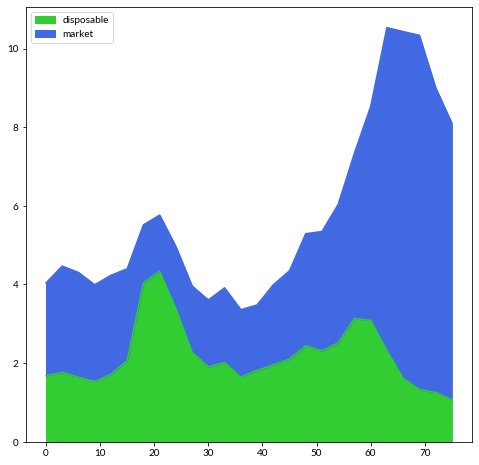

In [15]:
results3 = pd.DataFrame()
results3['disposable'] = (data.groupby('AGE_GRP')['SPM_GAP'].sum() / 3e9)# - results3['ca_gap']
results3['market'] = (data3.groupby('AGE_GRP')['MI_GAP'].sum() / 3e9) - results3['disposable']# - results3['ca_gap']

results3 = (results3 * (381.2 / 376.5)) # CPI-U-RS
results3.index = [i.left for i in results3.index]
results3.to_csv(data_dir / 'poor_age_prev.csv', index_label='age')
results3.iloc[::-1].plot(kind='area', stacked=True, figsize=(8,8), color=['limegreen', 'royalblue']);